In [101]:
import time
import numpy as np                  
import matplotlib.pyplot as plt   
import pandas as pd
import math
import statsmodels.api as sm
from math import sqrt
import os.path
import datetime 
import scipy.stats as stats

import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

import ffn

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.lda import LDA
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#from sklearn.qda import QDA
from sklearn.svm import LinearSVC, SVC
from keras.models import load_model

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))

# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0

# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')

# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")

# sort index
bitcoin_market_info.index = bitcoin_market_info['Date']
bitcoin_market_info.sort_index(inplace=True)

# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2013-04-28,2013-04-28,135.30,135.98,132.10,134.21,0,1488566728
2013-04-29,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865
2013-04-30,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125
2013-05-01,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594
2013-05-02,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495


In [3]:
bitcoin_market_info.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2019-09-26,2019-09-26,8487.67,8515.69,7895.63,8118.97,19258205289,145812492488
2019-09-27,2019-09-27,8113.10,8271.52,7965.92,8251.85,16408941156,148212635834
2019-09-28,2019-09-28,8251.27,8285.62,8125.43,8245.92,14141152736,148122503616
2019-09-29,2019-09-29,8246.04,8261.71,7990.50,8104.19,13034629109,145590374681
2019-09-30,2019-09-30,8104.23,8314.23,7830.76,8293.87,17115474183,149011567415


In [4]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))

# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names

# this will remove those asterisks
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

# sort index
eth_market_info.index = eth_market_info['Date']
eth_market_info.sort_index(inplace=True)

# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2015-08-07,2015-08-07,2.830000,3.540000,2.520000,2.770000,164329,166610555
2015-08-08,2015-08-08,2.790000,2.800000,0.714725,0.753325,674188,45486894
2015-08-09,2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,42399573
2015-08-10,2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,42818364
2015-08-11,2015-08-11,0.708087,1.130000,0.663235,1.070000,1463100,64569288


In [5]:
eth_market_info.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2019-09-26,2019-09-26,170.76,171.69,157.13,166.73,7848286154,17991000062
2019-09-27,2019-09-27,166.65,175.61,163.21,174.71,7909313625,18854855889
2019-09-28,2019-09-28,174.68,175.78,170.77,174.57,6895423445,18842313324
2019-09-29,2019-09-29,174.61,175.21,167.00,170.50,6497088199,18405401315
2019-09-30,2019-09-30,170.46,179.87,167.04,179.87,7552915148,19419149343


In [10]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

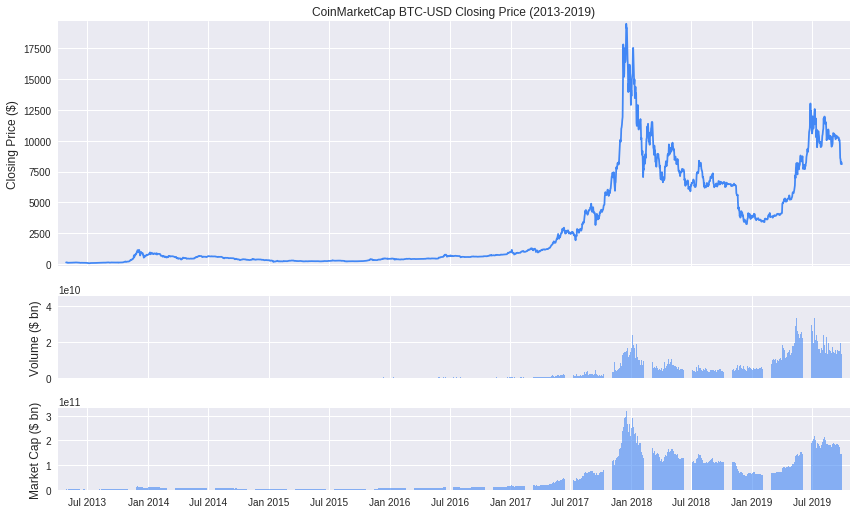

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[3, 1, 1], 'width_ratios':[0.75]},figsize=(12, 7.25))
ax1.set_title('CoinMarketCap BTC-USD Closing Price (2013-2019)')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax3.set_ylabel('Market Cap ($ bn)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax3.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'], color='#4287f5')
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values, color='#4287f5', alpha=0.6)
ax3.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Market Cap'].values, color='#4287f5', alpha=0.6)
ax1.margins(0.01)
ax2.margins(0.01)
ax3.margins(0.01)
fig.tight_layout()
plt.show();

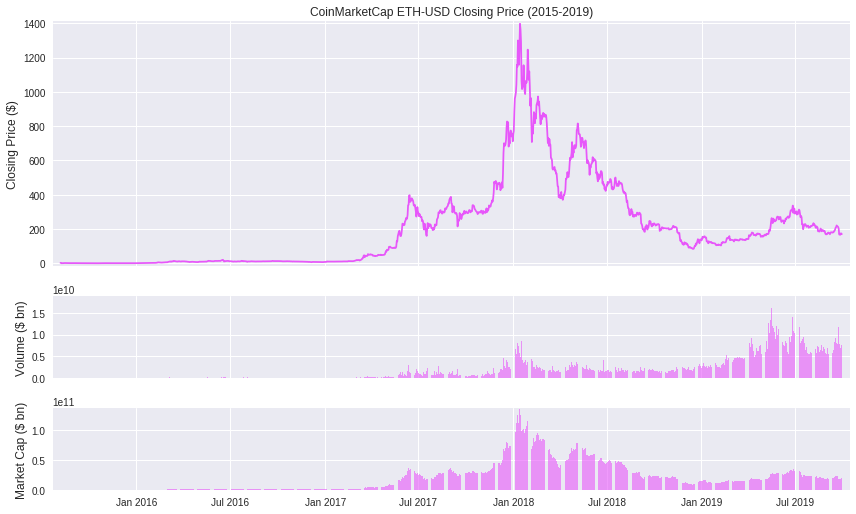

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[3, 1, 1], 'width_ratios':[0.75]},figsize=(12, 7.25))
ax1.set_title('CoinMarketCap ETH-USD Closing Price (2015-2019)')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax3.set_ylabel('Market Cap ($ bn)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2015,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticks([datetime.date(i,j,1) for i in range(2015,2020) for j in [1,7]])
ax3.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2015,2020) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'], color='#e757fa')
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values, color='#e757fa', alpha=0.6)
ax3.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Market Cap'].values, color='#e757fa', alpha=0.6)
ax1.margins(0.01)
ax2.margins(0.01)
ax3.margins(0.01)
fig.tight_layout()
plt.show();

In [13]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
    #market_info['bt_Volume_diff'] = market_info['bt_Volume'].pct_change()
    #market_info['eth_Volume_diff'] = market_info['eth_Volume'].pct_change()
    #market_info['bt_Market Cap_diff'] = market_info['bt_Market Cap'].pct_change()
    #market_info['eth_Market Cap_diff'] = market_info['eth_Market Cap'].pct_change()
    #market_info = market_info.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
147,2016-01-01,430.72,436.25,427.52,434.33,36278900,6529299589,0.933712,0.954822,0.931442,0.948024,206062,71980386,0.008381,0.015328
148,2016-01-02,434.62,436.06,431.87,433.44,30096600,6517390487,0.947401,0.969637,0.936560,0.937124,255504,71176658,-0.002715,-0.010848
149,2016-01-03,433.58,433.74,424.71,430.01,39633800,6467429942,0.938430,0.991362,0.934313,0.971905,407632,73843292,-0.008234,0.035671
150,2016-01-04,430.06,434.52,429.08,433.09,38477500,6515713340,0.972045,0.976438,0.929835,0.954480,346245,72543707,0.007046,-0.018070
151,2016-01-05,433.07,434.18,429.68,431.96,34522600,6500393256,0.953147,0.970597,0.946543,0.950176,219833,72240974,-0.002563,-0.003117


### Training, Test & Random Walks

We have some data, so now we need to build a model. In deep learning, the data is typically split into training and test sets. The model is built on the training set and subsequently evaluated on the unseen test set. In time series models, we generally train on one period of time and then test on another separate period. Rather arbitrarily, I'll set the cut-off date to June 1st 2017 (i.e. model will be trained on data before that date and assessed on data after it).

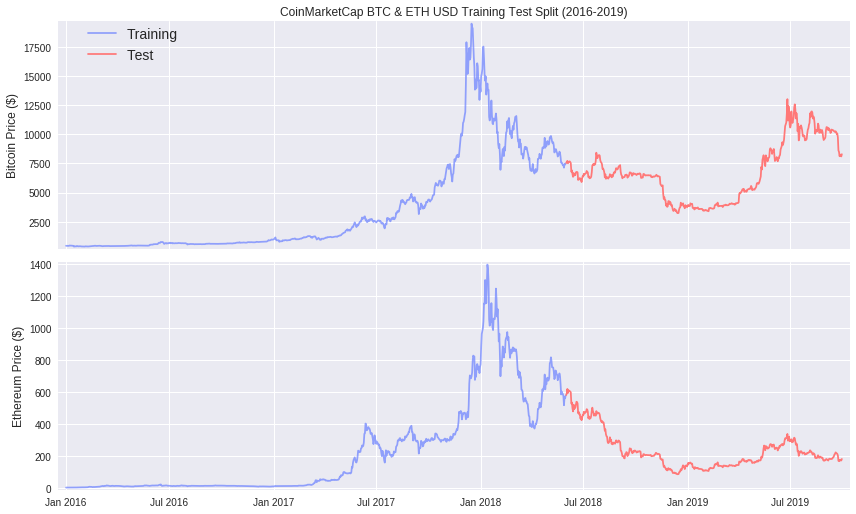

In [14]:
split_date = '2018-06-01'
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 7.25))
ax1.set_title('CoinMarketCap BTC & ETH USD Training Test Split (2016-2019)')
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#697fff', label='Training', alpha=0.7)
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#ff7878', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#697fff', alpha=0.7)
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#ff7878')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.margins(0.01)
ax2.margins(0.01)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

The most basic model is to set tomorrow's price equal to today's price (which we'll crudely call a lag model). This is how we'd define such a model in mathematical terms:

$$\begin{align}
Pred Price_{t}  = ActualPrice_{t-1}
\end{align}$$

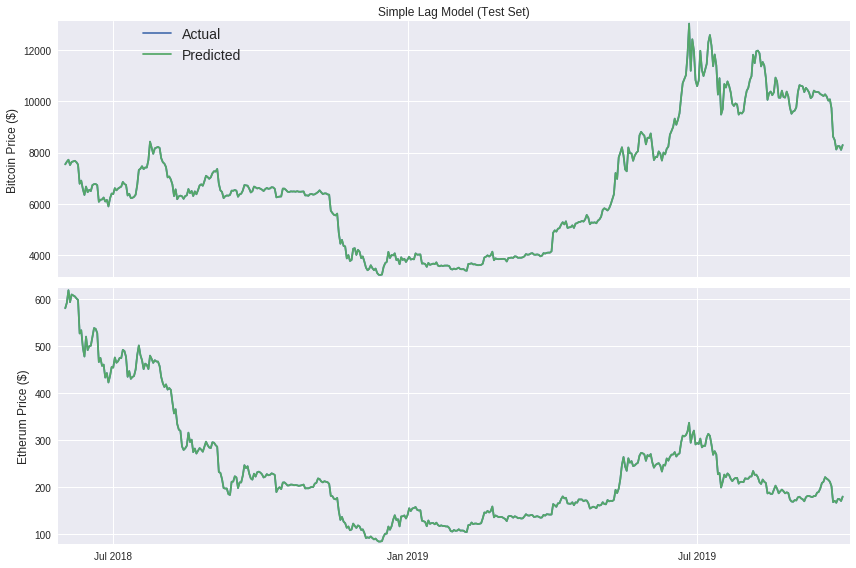

In [15]:
# trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2020) for j in [1,7]])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
ax1.margins(0.0089)
ax2.margins(0.0089)
fig.tight_layout()
plt.show()

Extending this trivial lag model, stock prices are commonly treated as random walks, which can be defined in these mathematical terms:

$$\begin{align}
Pred   Price_{t} = ActualPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)
\end{align}$$

We'll determine μ and σ from the training sets and apply the random walk model to the Bitcoin and Ethereum test sets.

First, we may want to make sure the daily change in price follows a normal distribution. We'll plot the histogram of values.

In [18]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 0.01) / n
    return(x,y)

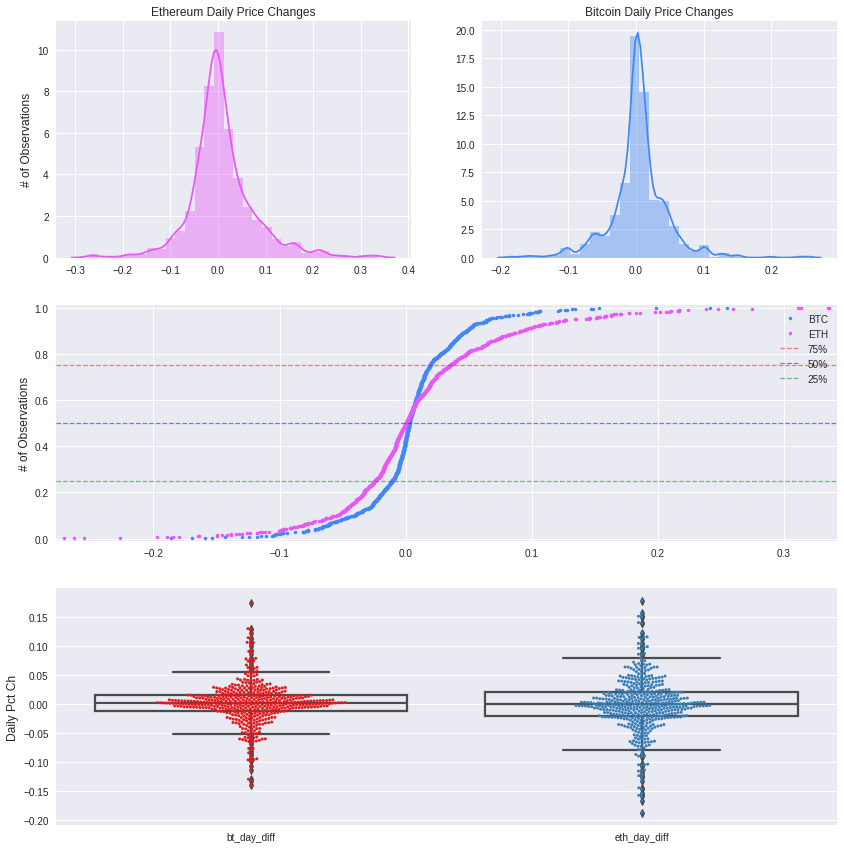

,bt_day_diff,eth_day_diff
count,487.000000,487.000000
mean,0.000931,-0.001325
std,0.035963,0.047485
min,-0.140915,-0.187799
25%,-0.012248,-0.021999
50%,0.001260,-0.001366
75%,0.014753,0.019647
max,0.173917,0.177502


In [61]:
plt.figure(figsize=(14, 20))

ax1 = plt.subplot(412)
ax1.margins(0.01)           

ax2 = plt.subplot(421)
ax2.margins(0.05)           

ax3 = plt.subplot(422)
ax3.margins(0.05)

ax4 = plt.subplot(413)
ax4.margins(0.05)

sns.distplot(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=30, ax=ax3, color='#4287f5')
sns.distplot(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=30, ax=ax2, color='#e757fa')
ax3.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
ax2.set_ylabel('# of Observations',fontsize=12)

x,y = ecdf(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
ax1.scatter(x=x, y=y, s=1)
ax1.plot(x,y, color = '#4287f5', label = 'BTC', marker='.', linestyle='none')

x,y = ecdf(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
ax1.scatter(x=x, y=y, s=1)
ax1.plot(x,y, color = '#e757fa', label = 'ETH', marker='.', linestyle='none')

ax1.axhline(y=0.75, color='red', linewidth=1.25, linestyle='dashed',label = '75%', alpha = 0.5)
ax1.axhline(y=0.5, color='blue', linewidth=1.25, linestyle='dashed',label = '50%', alpha = 0.5)
ax1.axhline(y=0.25, color='green', linewidth=1.25, linestyle='dashed',label = '25%', alpha = 0.5)

ax1.set_ylabel('# of Observations',fontsize=12)
ax1.legend()

pair = market_info[["bt_day_diff", "eth_day_diff"]]
pair.index = market_info['Date']
pair = pair.loc['2018-06-01':'2019-09-30']
pair_des = pd.DataFrame(pair.describe())
            
sns.boxplot(data=pair,linewidth=2.25,
            boxprops={'facecolor':'None'}, ax=ax4)

colors = sns.color_palette('Set1')
ax4.set_ylabel('Daily Pct Ch',fontsize=12)
sns.swarmplot(data=pair, palette="Set1", s=3, ax=ax4)
fig.tight_layout()

plt.show()

pair_des

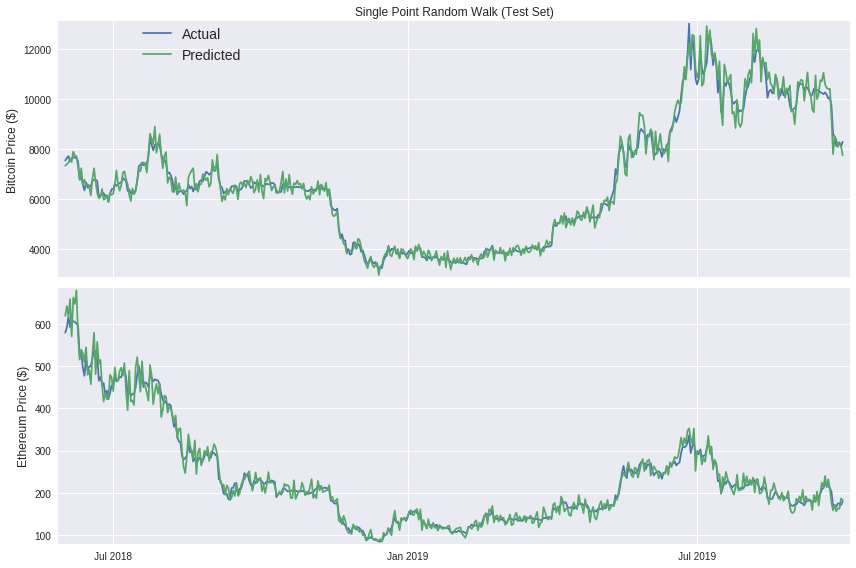

In [60]:
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2020) for j in [1,7]])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.margins(0.0089)
ax2.margins(0.0089)
plt.tight_layout()
plt.show()

In [66]:
pair = market_info[["bt_Close", "eth_Close"]]
pair.index = market_info['Date']
pair = pair.loc['2018-06-01':'2019-09-30']
pair['bt_Predicted'] = market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * (1+bt_random_steps)
pair['eth_Predicted'] = market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * (1+eth_random_steps)

pair.head()

,bt_Close,eth_Close,bt_Predicted,eth_Predicted
Date,,,,
2018-06-01,7541.45,580.04,7338.209042,619.971550
2018-06-02,7643.45,591.81,7397.604471,643.072890
2018-06-03,7720.25,618.33,7451.485658,618.576614
2018-06-04,7514.47,592.98,7619.144451,659.653095
2018-06-05,7633.76,609.30,7476.925604,570.915467


<Figure size 864x864 with 0 Axes>

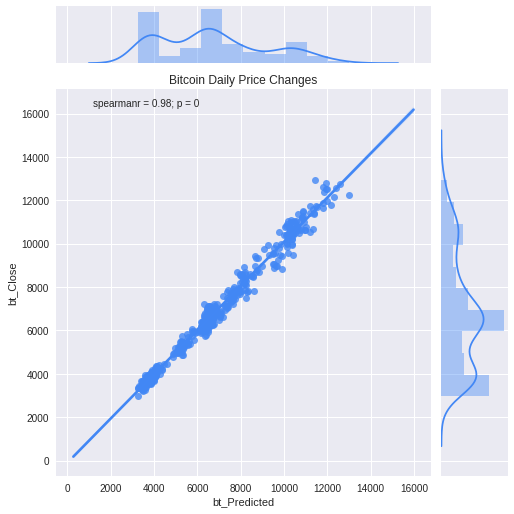

<Figure size 864x864 with 0 Axes>

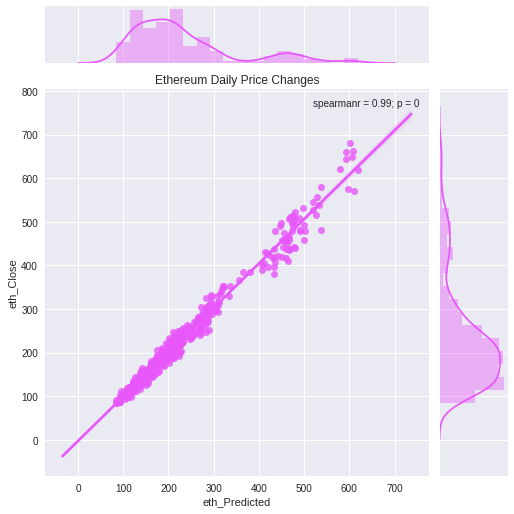

In [120]:
plt.figure(figsize=(12, 12))

sns.jointplot(pair['bt_Close'],
           pair['bt_Predicted'], kind='reg',color='#4287f5', size=7.25).annotate(stats.spearmanr)

plt.title('Bitcoin Daily Price Changes')
plt.xlabel('bt_Predicted')
plt.ylabel('bt_Close')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 12))

sns.jointplot(pair['eth_Close'],
           pair['eth_Predicted'], kind='reg',color='#e757fa', size=7.25).annotate(stats.spearmanr)

plt.title('Ethereum Daily Price Changes')
plt.xlabel('eth_Predicted')
plt.ylabel('eth_Close')
plt.tight_layout()
plt.show()

As pointed out on that other blog, models that only make predictions one point into the future are often misleadingly accurate, as errors aren't carried over to subsequent predictions. No matter how large the error, it's essentially reset at each time point, as the model is fed the true price. The Bitcoin random walk is particularly deceptive, as the scale of the y-axis is quite wide, making the prediction line appear quite smooth.

Single point predictions are unfortunately quite common when evaluating time series models. A better idea could be to measure its accuracy on multi-point predictions. That way, errors from previous predictions aren't reset but rather are compounded by subsequent predictions. Thus, poor models are penalised more heavily. In mathematical terms:

$$\begin{align}
PredPrice_{t}  = PredPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)\ \  \ PredPrice_0 = Price_0
\end{align}$$

Let's get our random walk model to predict the closing prices over the total test set.

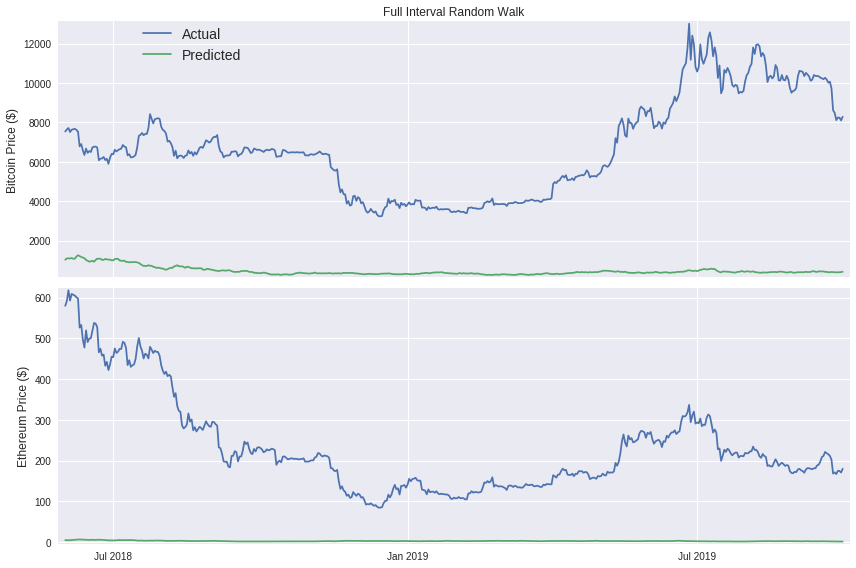

In [121]:
bt_random_walk = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))
        
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12, 8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2020) for j in [1,7]])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         bt_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         eth_random_walk[::-1], label='Predicted')

ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.margins(0.0089)
ax2.margins(0.0089)
plt.tight_layout()
plt.show()

The model predictions are extremely sensitive to the random seed. I've selected one where the full interval random walk looks almost decent for Ethereum. 

In [123]:
def plot_func(freq):
    np.random.seed(freq)
    random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
    random_walk = []
    for n_step,i in enumerate(random_steps):
        if n_step==0:
            random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (i+1))
        else:
            random_walk.append(random_walk[n_step-1] * (i+1))
            
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 8))
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2020) for j in [1,7]])
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps), label='Predicted')
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps))
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
             random_walk[::-1])
    ax1.set_title('Single Point Random Walk')
    ax1.set_ylabel('')
    # for static figures, you may wish to insert the random seed value
#    ax1.annotate('Random Seed: %d'%freq, xy=(0.75, 0.2),  xycoords='axes fraction',
#            xytext=(0.75, 0.2), textcoords='axes fraction')
    ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax2.set_title('Full Interval Random Walk')
    fig.text(0.0, 0.5, 'Ethereum Price ($)', va='center', rotation='vertical',fontsize=12)
    ax1.margins(0.0089)
    ax2.margins(0.0089)
    plt.tight_layout()
#    plt.savefig('image%d.png'%freq, bbox_inches='tight')
    plt.show()
    
interact(plot_func, freq =widgets.IntSlider(min=200,max=210,step=1,value=205, description='Random Seed:'))

interactive(children=(IntSlider(value=205, description='Random Seed:', max=210, min=200), Output()), _dom_clas…

<function __main__.plot_func(freq)>

Notice how the single point random walk always looks quite accurate, even though there's no real substance behind it.

### Long Short Term Memory (LSTM)

There exists packages that include standard implementations of various deep learning algorithms (e.g. TensorFlow, Keras, PyTorch, etc.). I'll opt for Keras, as I find it the most intuitive for non-experts. 

In [124]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [125]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
147,2016-01-01,434.33,36278900,-0.560137,0.020268,0.948024,206062,-0.418477,0.025040
148,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
149,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
150,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
151,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


I've created a new data frame called model_data. I've removed some of the previous columns (open price, daily highs and lows ect.) and reformulated some new ones. close_off_high represents the gap between the closing price and price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively. The volatility columns are simply the difference between high and low price divided by the opening price. You may also notice that model_data is arranged in order of earliest to latest. We don't actually need the date column anymore, as that information won't be fed into the model.

Our LSTM model will use previous data (both bitcoin and eth) to predict the next day's closing price of a specific coin. We must decide how many previous days it will have access to. Again, it's rather arbitrary, but I'll opt for 10 days, as it's a nice round number. We build little data frames consisting of 10 consecutive days of data (called windows), so the first window will consist of the 0-9th rows of the training set (Python is zero-indexed), the second will be the rows 1-10, etc. Picking a small window size means we can feed more windows into our model; the downside is that the model may not have sufficient information to detect complex long term behaviours (if such things exist).

Deep learning models don't like inputs that vary wildly. Looking at those columns, some values range between -1 and 1, while others are on the scale of millions. We need to normalise the data, so that our inputs are somewhat consistent. Typically, you want values between -1 and 1. The off_high and volatility columns are fine as they are. For the remaining columns, like that other blog post, we'll normalise the inputs to the first value in the window.

In [126]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [127]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [128]:
# training input
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [129]:
# testing input
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [130]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
147,0.000000,0.000000,-0.560137,0.020268,0.000000,0.000000,-0.418477,0.025040
148,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
149,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
150,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
151,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
152,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
153,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
154,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
155,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
156,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


This table represents an example of our LSTM model input (we'll actually have hundreds of similar tables). We've normalised some columns so that their values are equal to 0 in the first time point, so we're aiming to predict changes in price relative to this timepoint. We're now ready to build the LSTM model. This is actually quite straightforward with Keras, you simply stack componenets on top of each other.

In [131]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [132]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [133]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

So, the build_model functions constructs an empty model unimaginatively called model (model = Sequential), to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m tables, where n and m represent the number of timepoints/rows and columns, respectively). The function also includes more generic neural network features, like dropout and activation functions. Now, we just need to specify the number of neurons to place in the LSTM layer (I've opted for 20 to keep runtime reasonable), as well as the data on which the model will be trained.

In [134]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 3s - loss: 0.1355
Epoch 2/50
 - 2s - loss: 0.0901
Epoch 3/50
 - 2s - loss: 0.0816
Epoch 4/50
 - 2s - loss: 0.0791
Epoch 5/50
 - 2s - loss: 0.0745
Epoch 6/50
 - 2s - loss: 0.0703
Epoch 7/50
 - 2s - loss: 0.0698
Epoch 8/50
 - 2s - loss: 0.0681
Epoch 9/50
 - 2s - loss: 0.0690
Epoch 10/50
 - 2s - loss: 0.0669
Epoch 11/50
 - 2s - loss: 0.0656
Epoch 12/50
 - 2s - loss: 0.0654
Epoch 13/50
 - 2s - loss: 0.0639
Epoch 14/50
 - 2s - loss: 0.0618
Epoch 15/50
 - 2s - loss: 0.0635
Epoch 16/50
 - 2s - loss: 0.0635
Epoch 17/50
 - 2s - loss: 0.0638
Epoch 18/50
 - 2s - loss: 0.0615
Epoch 19/50
 - 2s - loss: 0.0629
Epoch 20/50
 - 2s - loss: 0.0626
Epoch 21/50
 - 2s - loss: 0.0617
Epoch 22/50
 - 2s - loss: 0.0618
Epoch 23/50
 - 2s - loss: 0.0625
Epoch 24/50
 - 2s - loss: 0.0615
Epoch 25/50
 - 2s - loss: 0.0606
Epoch 26/50
 - 2s - loss: 0.0644
Epoch 27/50
 - 2s - loss: 0.0626
Epoch 28/50
 - 2s - loss: 0.0605
Epoch 29/50
 - 2s - loss: 0.0602
Epoch 30/50
 - 2s - loss: 0.0632
Epoch 31/50
 - 2s -

If everything went to plan, then we'd expect the training error to have gradually decreased over time.

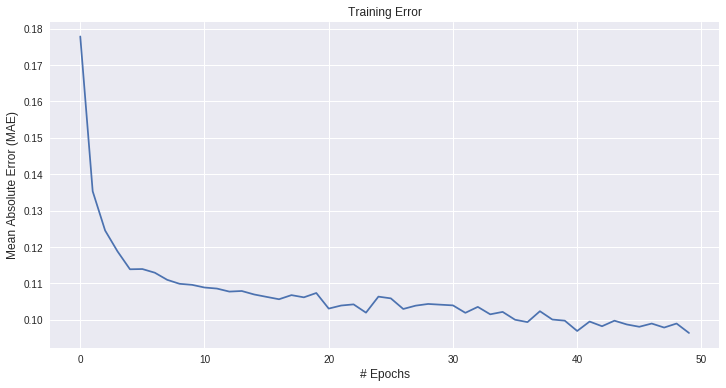

In [159]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))


ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

We've just built an LSTM model to predict tomorrow's Ethereum closing price. Let's see how well it performs. We start by examining its performance on the training set (data before June 2017). That number below the code represents the model's mean absolute error (mae) on the training set after the 50th training iteration (or epoch). Instead of relative changes, we can view the model output as daily closing prices.

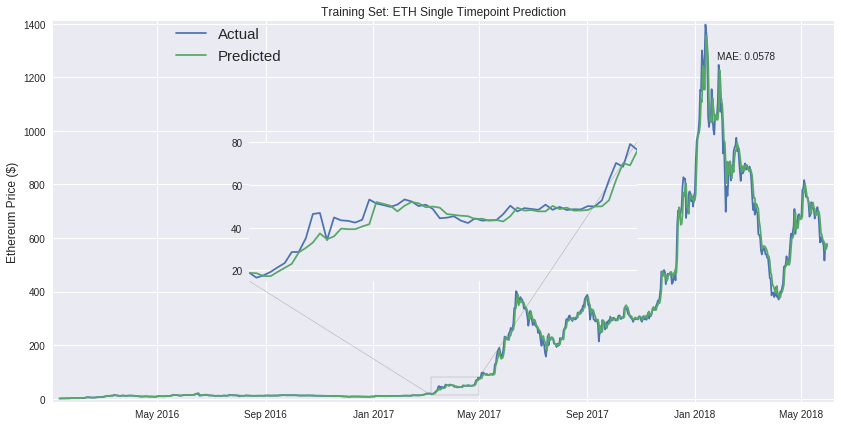

In [136]:
fig, ax1 = plt.subplots(1,1,figsize=(14, 7))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: ETH Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 15})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.85, 0.9),  xycoords='axes fraction',
            xytext=(0.85, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 8, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 7), datetime.date(2017, 5, 1)])
axins.set_ylim([15,80])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
ax1.margins(0.0089)
axins.margins(0.0089)
plt.show()

We shouldn't be too surprised by its apparent accuracy here. The model could access the source of its error and adjust itself accordingly. In fact, it's not hard to attain almost zero training errors. We could just cram in hundreds of neurons and train for thousands of epochs (a process known as overfitting, where you're essentially predicting noise- I included the Dropout() call in the build_model function to mitigate this risk for our relatively small model). We should be more interested in its performance on the test dataset, as this represents completely new data for the model.

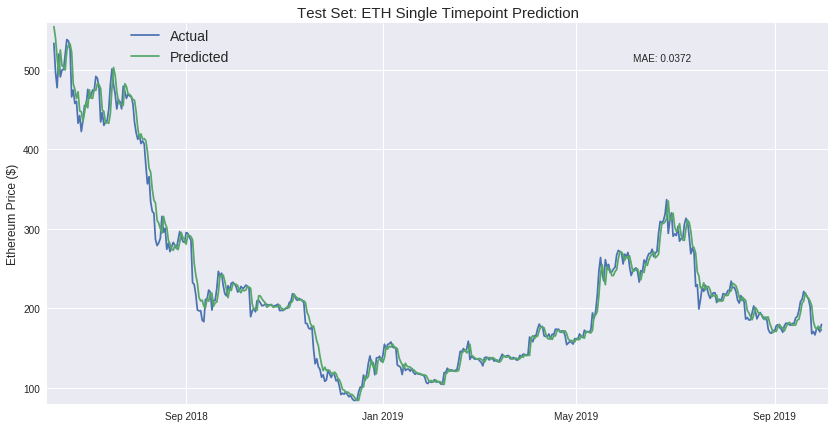

In [137]:
fig, ax1 = plt.subplots(1,1,figsize=(14, 7))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: ETH Single Timepoint Prediction',fontsize=15)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.margins(0.0089)
plt.show()

Caveats aside about the misleading nature of single point predictions, our LSTM model seems to have performed well on the unseen test set. The model seems to be systemically overestimating the future value of Ether (join the club, right?), as the predicted line near always runs higher than the actual line. I suspect this is because the training data represents a period during which the price of Ether rose astronomically, so it expects that trend to continue (don't we all). We can also build a similar LSTM model for Bitcoin- test set predictions are plotted below.

In [138]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 2s - loss: 0.0819
Epoch 2/50
 - 2s - loss: 0.0551
Epoch 3/50
 - 2s - loss: 0.0492
Epoch 4/50
 - 2s - loss: 0.0438
Epoch 5/50
 - 2s - loss: 0.0434
Epoch 6/50
 - 2s - loss: 0.0406
Epoch 7/50
 - 2s - loss: 0.0400
Epoch 8/50
 - 2s - loss: 0.0377
Epoch 9/50
 - 2s - loss: 0.0395
Epoch 10/50
 - 2s - loss: 0.0375
Epoch 11/50
 - 2s - loss: 0.0362
Epoch 12/50
 - 2s - loss: 0.0364
Epoch 13/50
 - 2s - loss: 0.0374
Epoch 14/50
 - 2s - loss: 0.0359
Epoch 15/50
 - 2s - loss: 0.0352
Epoch 16/50
 - 2s - loss: 0.0359
Epoch 17/50
 - 2s - loss: 0.0364
Epoch 18/50
 - 2s - loss: 0.0363
Epoch 19/50
 - 2s - loss: 0.0353
Epoch 20/50
 - 2s - loss: 0.0333
Epoch 21/50
 - 2s - loss: 0.0336
Epoch 22/50
 - 2s - loss: 0.0347
Epoch 23/50
 - 2s - loss: 0.0345
Epoch 24/50
 - 2s - loss: 0.0336
Epoch 25/50
 - 2s - loss: 0.0337
Epoch 26/50
 - 2s - loss: 0.0349
Epoch 27/50
 - 2s - loss: 0.0339
Epoch 28/50
 - 2s - loss: 0.0333
Epoch 29/50
 - 2s - loss: 0.0342
Epoch 30/50
 - 2s - loss: 0.0340
Epoch 31/50
 - 2s -

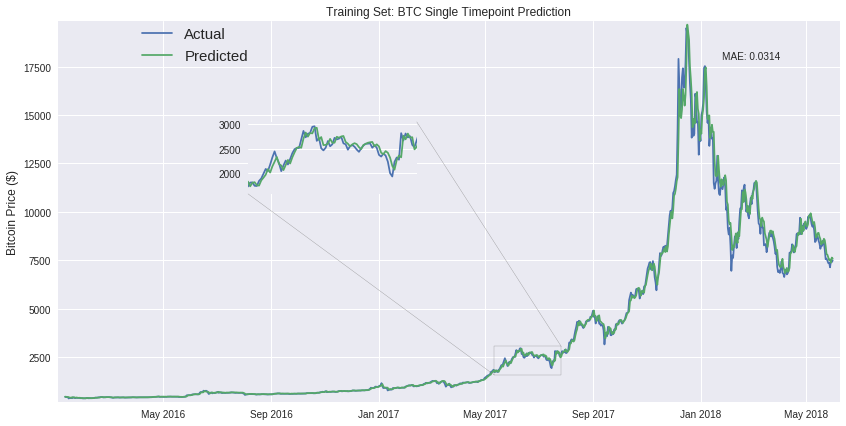

In [139]:
fig, ax1 = plt.subplots(1,1,figsize=(14, 7))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: BTC Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.85, 0.9),  xycoords='axes fraction',
            xytext=(0.85, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 15})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 5, 12), datetime.date(2017, 7, 27)])
axins.set_ylim([1575, 3050])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
ax1.margins(0.0089)
axins.margins(0.0089)
plt.show()

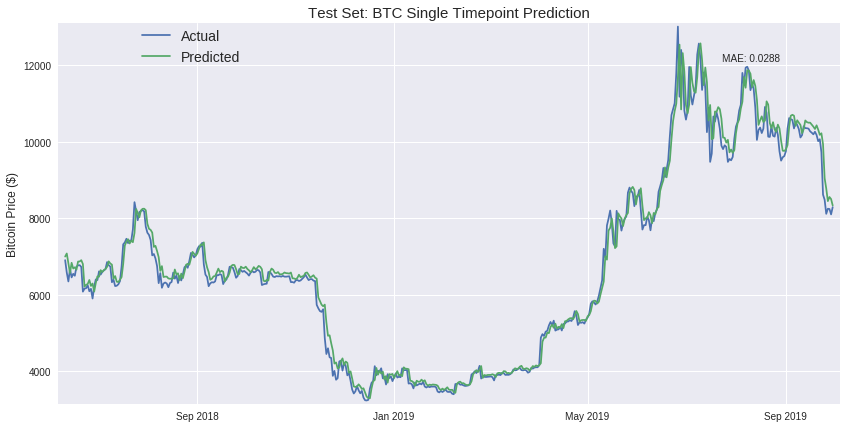

In [140]:
fig, ax1 = plt.subplots(1,1,figsize=(14, 7))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2020) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2020) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.85, 0.9),  xycoords='axes fraction',
            xytext=(0.85, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: BTC Single Timepoint Prediction',fontsize=15)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.margins(0.0089)
plt.show()

As I've stated earlier, single point predictions can be deceptive. Looking more closely, you'll notice that, again, the predicted values regularly mirror the previous values (e.g. October). Our fancy deep learning LSTM model has partially reproducted a autregressive (AR) model of some order p, where future values are simply the weighted sum of the previous p values. We can define an AR model in these mathematical terms:

$$\begin{align}
PredPrice_{t}  = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}$$

The good news is that AR models are commonly employed in time series tasks (e.g. stock market prices), so the LSTM model appears to have landed on a sensible solution. The bad news is that it's a waste of the LSTM capabilities, we could have a built a much simpler AR model in much less time and probably achieved similar results. More complex does not automatically equal more accurate.

We'll now build LSTM models to predict crypto prices for the next 5 days.

In [141]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 2s - loss: 0.1778
Epoch 2/50
 - 2s - loss: 0.1353
Epoch 3/50
 - 2s - loss: 0.1245
Epoch 4/50
 - 2s - loss: 0.1188
Epoch 5/50
 - 2s - loss: 0.1139
Epoch 6/50
 - 2s - loss: 0.1140
Epoch 7/50
 - 2s - loss: 0.1129
Epoch 8/50
 - 2s - loss: 0.1110
Epoch 9/50
 - 2s - loss: 0.1099
Epoch 10/50
 - 2s - loss: 0.1096
Epoch 11/50
 - 2s - loss: 0.1089
Epoch 12/50
 - 2s - loss: 0.1086
Epoch 13/50
 - 2s - loss: 0.1078
Epoch 14/50
 - 2s - loss: 0.1079
Epoch 15/50
 - 2s - loss: 0.1070
Epoch 16/50
 - 2s - loss: 0.1063
Epoch 17/50
 - 2s - loss: 0.1057
Epoch 18/50
 - 2s - loss: 0.1068
Epoch 19/50
 - 2s - loss: 0.1062
Epoch 20/50
 - 2s - loss: 0.1074
Epoch 21/50
 - 2s - loss: 0.1031
Epoch 22/50
 - 2s - loss: 0.1039
Epoch 23/50
 - 2s - loss: 0.1042
Epoch 24/50
 - 2s - loss: 0.1020
Epoch 25/50
 - 2s - loss: 0.1064
Epoch 26/50
 - 2s - loss: 0.1059
Epoch 27/50
 - 2s - loss: 0.1030
Epoch 28/50
 - 2s - loss: 0.1039
Epoch 29/50
 - 2s - loss: 0.1044
Epoch 30/50
 - 2s - loss: 0.1042
Epoch 31/50
 - 2s -

In [142]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 2s - loss: 0.1054
Epoch 2/50
 - 2s - loss: 0.0757
Epoch 3/50
 - 2s - loss: 0.0657
Epoch 4/50
 - 2s - loss: 0.0642
Epoch 5/50
 - 2s - loss: 0.0616
Epoch 6/50
 - 2s - loss: 0.0605
Epoch 7/50
 - 2s - loss: 0.0603
Epoch 8/50
 - 2s - loss: 0.0584
Epoch 9/50
 - 2s - loss: 0.0590
Epoch 10/50
 - 2s - loss: 0.0566
Epoch 11/50
 - 2s - loss: 0.0559
Epoch 12/50
 - 2s - loss: 0.0563
Epoch 13/50
 - 2s - loss: 0.0568
Epoch 14/50
 - 2s - loss: 0.0549
Epoch 15/50
 - 2s - loss: 0.0565
Epoch 16/50
 - 2s - loss: 0.0560
Epoch 17/50
 - 2s - loss: 0.0564
Epoch 18/50
 - 2s - loss: 0.0553
Epoch 19/50
 - 2s - loss: 0.0557
Epoch 20/50
 - 2s - loss: 0.0552
Epoch 21/50
 - 2s - loss: 0.0555
Epoch 22/50
 - 2s - loss: 0.0556
Epoch 23/50
 - 2s - loss: 0.0548
Epoch 24/50
 - 2s - loss: 0.0545
Epoch 25/50
 - 2s - loss: 0.0546
Epoch 26/50
 - 2s - loss: 0.0560
Epoch 27/50
 - 2s - loss: 0.0541
Epoch 28/50
 - 2s - loss: 0.0528
Epoch 29/50
 - 2s - loss: 0.0542
Epoch 30/50
 - 2s - loss: 0.0547
Epoch 31/50
 - 2s -

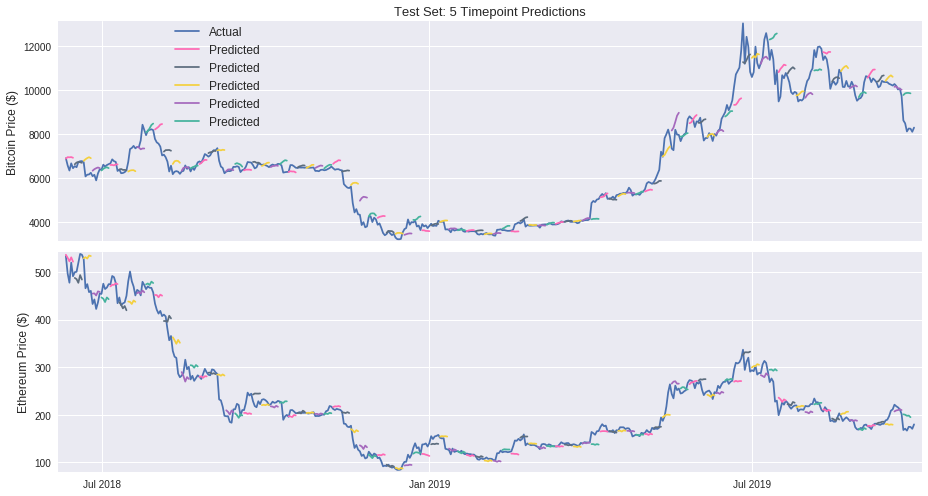

In [143]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(13, 7))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax2.set_xticks([datetime.date(i,j,1) for i in range(2018,2020) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2020) for j in [1,7]])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
ax1.margins(0.0089)
ax2.margins(0.0089)
plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

In [144]:
# warning: this cell may take some time to execute
# this code builds 5 LSTM models for eth and bitcoin each (with 5 different initialisations)
# the models are then saved so you hopefully only need to run this cell once

# random seed for reproducibility
for rand_seed in range(775,780):
    print(rand_seed)
    np.random.seed(rand_seed)
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs,
                 (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1,
                epochs=50, batch_size=1, verbose=0, shuffle=True)
    temp_model.save('eth_model_randseed_%d.h5'%rand_seed)
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs,
                 (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1,
               epochs=50, batch_size=1, verbose=0, shuffle=True)
    temp_model.save('bt_model_randseed_%d.h5'%rand_seed)

775
776
777
778
779


In [145]:
# assuming the previous cell was completed, this cell loads in the different initialisations
# and calculates the average mean absolute error (mae)

eth_preds = []
bt_preds = []
for rand_seed in range(775,780):
    temp_model = load_model('eth_model_randseed_%d.h5'%rand_seed)
    eth_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['eth_Close'].values[window_len:]/test_set['eth_Close'].values[:-window_len]-1))))
    temp_model = load_model('bt_model_randseed_%d.h5'%rand_seed)
    bt_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['bt_Close'].values[window_len:]/test_set['bt_Close'].values[:-window_len]-1))))

In [147]:
eth_random_walk_preds = []
bt_random_walk_preds = []
for rand_seed in range(775,780):
    np.random.seed(rand_seed)
    eth_random_walk_preds.append(
        np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['eth_Close'][window_len:])/np.array(test_set['eth_Close'][:-window_len]))))
    bt_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(bt_r_walk_mean, bt_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['bt_Close'][window_len:])/np.array(test_set['bt_Close'][:-window_len]))))

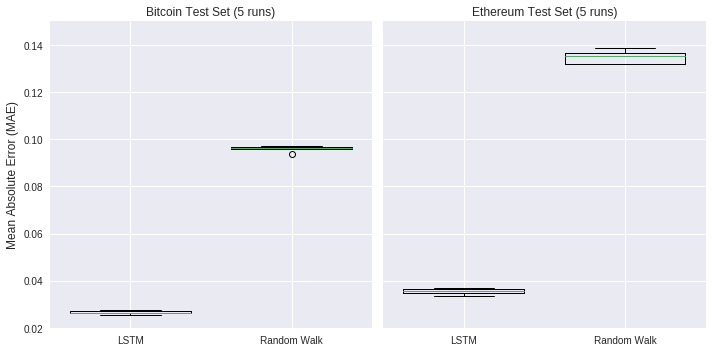

In [157]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.boxplot([bt_preds, bt_random_walk_preds],widths=0.75)
ax1.set_ylim([0.02, 0.15])
ax2.boxplot([eth_preds, eth_random_walk_preds],widths=0.75)
ax2.set_ylim([0.02, 0.15])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Bitcoin Test Set (5 runs)')
ax2.set_title('Ethereum Test Set (5 runs)')
ax2.set_yticklabels('')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
fig.tight_layout()
plt.show()

Maybe AI is worth the hype after all! Those graphs show the error on the test set after 5 different initialisations of each model. The LSTM model returns an average error of about 0.04 and 0.05 on the bitcoin and eth prices, respectively, crushing the corresponding random walk models.

Aiming to beat random walks is a pretty low bar. It would be more interesting to compare the LSTM model against more appropriate time series models (weighted average, autoregression, ARIMA or Facebook's Prophet algorithm). On the other hand, I'm sure it wouldn't be hard to improve our LSTM model (gratuitously adding more layers and/or neurons, changing the batch size, learning rate, etc.).

### Summary

We've collected some crypto data and fed it into a supercool deeply intelligent machine learning LSTM model. Unfortunately, its predictions were not that different from just spitting out the previous value. How can we make the model learn more sophisticated behaviours?

Change Loss Function: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. More bespoke trading focused loss functions could also move the model towards less conservative behaviours.

Penalise conservative AR-type models: This would incentivise the deep learning algorithm to explore more risky/interesting models. Easier said than done!

Get more and/or better data: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.

If that's the positive spin, then the negative reality is that it's entirely possible that there is no detectable pattern to changes in crypto prices; that no model (however deep) can separate the signal from the noise (similar to the merits of using deep learning to predict earthquakes). And any pattern that does appear can disappear as quickly (see efficient market hypothesis). Just think how different Bitcoin in 2016 is to craze-riding Bitcoin of late 2019. Any model built on 2016 data would surely struggle to replicate these unprecedented movements.